# Dask Bag (2)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Map-Reduce"
* https://docs.dask.org/en/latest/bag.html
* Jesse C. Daniel. Data Science with Python and Dask. 
* https://realpython.com/python-reduce-function/
* https://docs.python.org/3/library/calendar.html

## Задачи для совместного разбора

In [1]:
import dask.bag as db
import json
from functools import reduce

In [2]:
with open("posts.json") as fp:
    posts = json.load(fp)
posts_bag = db.from_sequence(posts, npartitions=2)

In [5]:
posts[0]

{'userId': 1,
 'id': 1,
 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit',
 'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'}

In [6]:
sum(len(post['title']) for post in posts)

3952

1. Посчитайте суммарную длину длин описаний постов

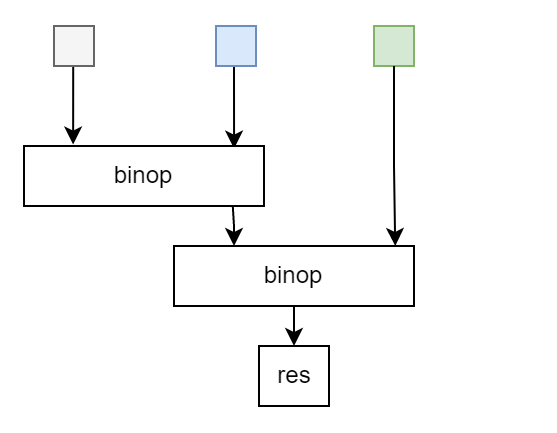

In [9]:
reduce(
    lambda acc, val: acc + val,
    map(
        lambda p: len(p['title']),
        posts
    ),
    -1000
)

2952

In [10]:
posts_bag.take(1)

({'userId': 1,
  'id': 1,
  'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit',
  'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'},)

In [11]:
titles = posts_bag.map(lambda p: len(p['title']))
titles.take(1)

(74,)

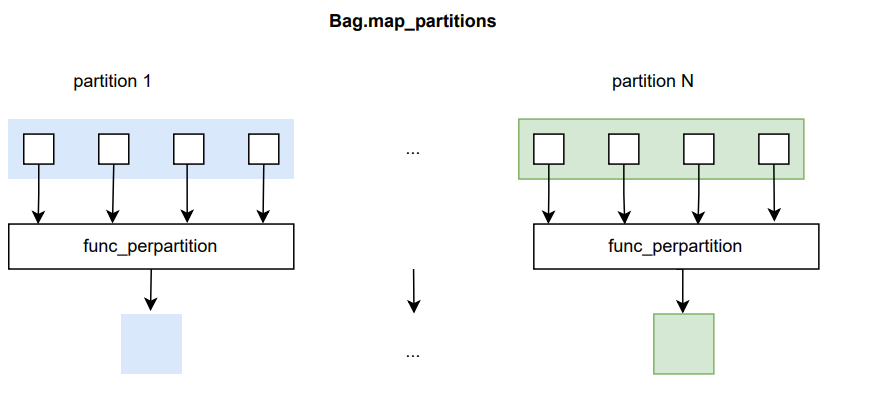

In [12]:
titles

dask.bag<lambda, npartitions=2>

In [13]:
def f(partition):
    return sum(partition)
    
titles.map_partitions(f).compute()

(1944, 2008)

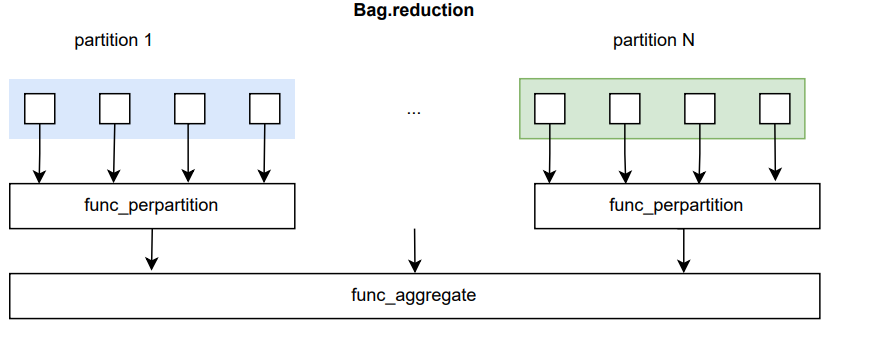

In [14]:
def func_perpartition(partition):
    return sum(partition)

def func_aggregate(portition_results):
    return sum(portition_results)

titles.reduction(func_perpartition, func_aggregate).compute()

3952

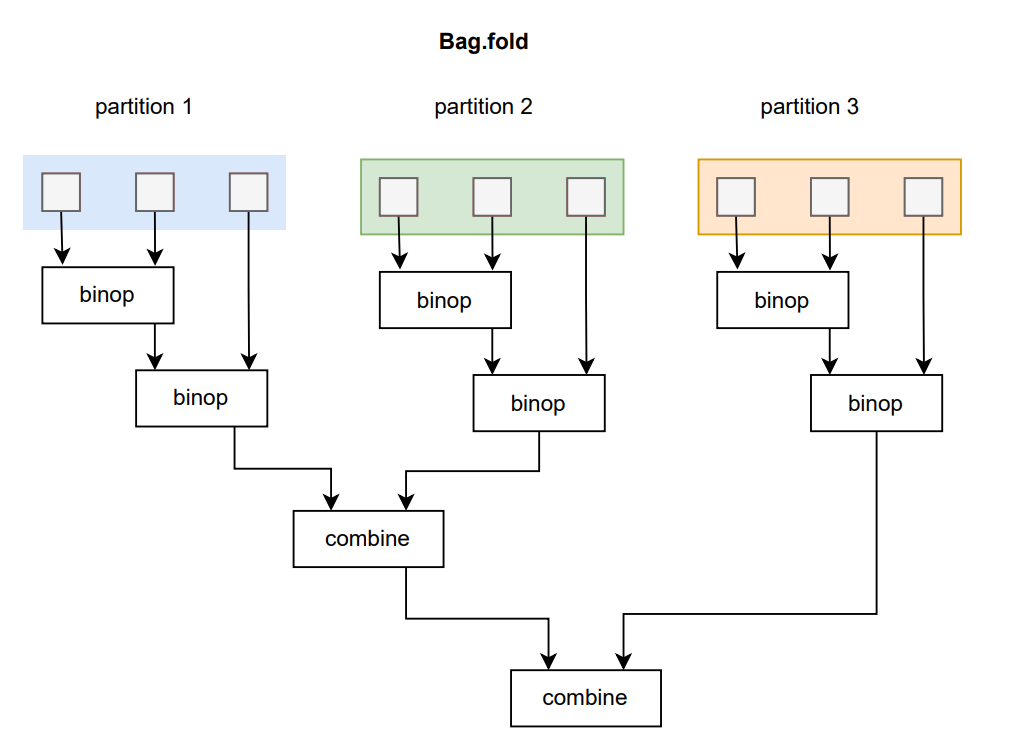

In [16]:
titles.fold(
    binop=lambda acc, val: acc + val,
    #combine=lambda acc, val: acc + val
).compute()

3952

2. При помощи метода `foldby` посчитайте, сколько постов написал каждый из пользователей.

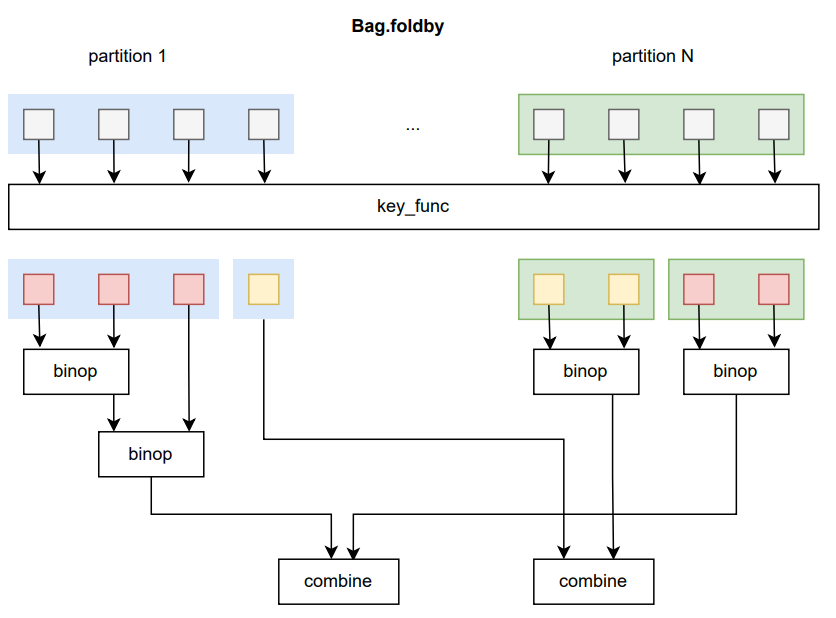

In [18]:
posts_bag.foldby(
    key=lambda p: p["userId"],
    binop=lambda acc, val: acc + 1, # для группы с меткой
    initial=0,
    combine=lambda acc, val: acc + val, # для сегментов
    combine_initial=0
).compute()

[(1, 10),
 (2, 10),
 (3, 10),
 (4, 10),
 (5, 10),
 (6, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (10, 10)]

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к любым другим структурам возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

<p class="task" id="1"></p>

1\. Загрузите отзывы из файла `reviews_1.json` в виде списка. Используя `functools.reduce`, сгенерируйте словарь, содержащий частоты слов, встречающихся в отзывах из этого файла. Для разбиения на слова используйте объект `tokenizer`. Перед разбиением на слова приведите текст отзыва к нижнему регистру. Выведите на экран длину полученного словаря.


In [1]:
import dask.bag as db
import json
from functools import reduce

In [2]:
reviews = []
with open("reviews_1.json") as fp:
    for line in fp:
        reviews.append(json.loads(line))

In [83]:
len(reviews)

102679

In [42]:
def search_review(text):
    review = str(text['review']).lower()
    return review

In [50]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [76]:
tokens = tokenizer.tokenize(' '.join(list(map(search_review, reviews))))

In [106]:
def counts(dct, val):
    dct[val] = dct.get(val, 0) + 1
    return dct

In [107]:
freqs = reduce(counts, tokens, {})
len(freqs)

41570

<p class="task" id="2"></p>

2\. Общее количество символов, которое занимает слово во всех отзывах, можно рассчитать, умножив длину этого слова на частоту использования этого слова. Используя `functools.reduce`, найдите слово, которое занимает больше всего символов в отзывах из файла `reviews_1.json` (воспользуйтесь результатами из задачи 1). Выведите найденное слово и количество занимаемых им символов на экран. Решите ту же задачу при помощи функции `max`.

In [132]:
def max_freq(acc, val):
    if val[1] * len(val[0]) > acc[1] * len(acc[0]):
        return val
    return acc

In [142]:
ans = reduce(max_freq, list(freqs.items()))
print(ans)
ans[0], ans[1]*len(ans[0])

('the', 237252)


('the', 711756)

In [145]:
max(
    list(
        map(
            lambda x: (x[0], x[1] * len(x[0])), list(freqs.items())
        )
    ), key=lambda x: x[1]
)

('the', 711756)

<p class="task" id="3"></p>

3\. Будем считать, что сегмент _плохо перемешан_, если в нем _подряд_ идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `Bag.map_partitions`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `reviews_bag`. 

In [2]:
import dask.bag as db
import json
# Перед выполнением убедитесь, что у вас существует папка data/reviews_full
reviews_bag = db.read_text(
    "reviews_full/*.json", blocksize="128MiB"
).map(json.loads)

In [3]:
dates = reviews_bag.map(lambda x: x['date'].split('-')[0])

In [12]:
from itertools import groupby
def grouped_parts(part):
    max_len = max(
        map(len, [list(y) for x, y in groupby(part)])
    )
    if max_len >= 5:
        return 1
    else: 
        return 0

In [12]:
res = dates.map_partitions(
    grouped_parts
).compute()
res

(0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1)

In [13]:
sum(res)

17

<p class="task" id="4"></p>

4\. Будем считать, что сегмент _плохо перемешан_, если в нем подряд идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `Bag.reduction`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `reviews_bag`.

In [14]:
dates = reviews_bag.map(lambda x: x['date'].split('-')[0])

In [16]:
def func_perpartition(partition):
    max_len = max(
        map(len, [list(y) for x, y in groupby(partition)])
    )
    if max_len >= 5:
        return 1
    else: 
        return 0
def func_aggregate(portition_results):
    return sum(portition_results)

dates.reduction(func_perpartition, func_aggregate).compute()

17

<p class="task" id="5"></p>

5\. Будем считать, что сегмент _плохо перемешан_, если в нем подряд идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `fold`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `reviews_bag`.

Примечание 1: один из возможных вариантов реализации функции свертки заключается в использовании кортежей, содержащих год и кол-во раз, которое этот год встретился подряд.

Примечание 2: dask автоматически объединяет сегменты в группы размера `split_every`. Из-за этого во время шага `combine` могут возникнуть проблемы с типом входных данных. Вы можете упростить функцию `combine`, выставив достаточно большое значение `split_every`.

In [128]:
dates = reviews_bag.map(lambda x: x['date'].split('-')[0])

In [4]:
def f(acc, val):
    try:
        if val == acc[-1][-1]:
            acc[-1].append(val)
            return acc
    except TypeError:
        pass
    except IndexError:
        pass
    acc.append([val])
    return acc

In [80]:
def sum_len(acc, val):
    ### 
    if type(acc) == list:
        acc = 1
        return acc
    try:
        val = list(map(lambda x: len(x), val))
        val = len(list(filter(lambda x: x >= 5, val)))
        if val >= 1:
            return acc + 1
    except TypeError:
        pass
    return acc

In [91]:
dates.fold(binop=f, combine=sum_len, initial=[], split_every=1000000).compute()

17

<p class="task" id="6"></p>

6\.  При помощи метода `accumulate` для каждого $i$-го отзыва расчитайте, столько отзывов из 2010 года было оставлено среди первых $i$ элементов. Воспользовавшись полученным результатом и расчитав общее количество элементов в `reviews_bag`, выберите `k` первых строк объекта `reviews_bag` таким образом, чтобы в выбранном множестве оказалось ровно 10 тыс. отзывов, оставленных в 2010 году. Подтвердите правильность решения, выведя количество элементов в выбранном множестве, которые были оставлены в 2010 году.

In [102]:
def acc_func(acc, val):
    if val['date'].split('-')[0] == '2010':
        return acc + 1
    return acc

In [104]:
reviews_bag.accumulate(acc_func, initial=0).compute()

OSError: [WinError 1450] Недостаточно системных ресурсов для завершения операции

In [127]:
reviews_bag.count().compute()

9057540

In [119]:
reviews_bag_short = reviews_bag.take(3_000_000, compute=False)
accumulated_res = reviews_bag_short.accumulate(acc_func, initial=0).compute()

In [120]:
10000 in accumulated_res

True

In [122]:
ind = accumulated_res.index(10_000)
ind

244188

In [126]:
reviews_bag_ten = reviews_bag.take(ind, compute=False)

len(reviews_bag_ten.filter(lambda x: x['date'].split('-')[0] == '2010').compute())

10000

<p class="task" id="7"></p>

7\. Посчитайте, сколько отзывов оставили пользователи в каждом месяце каждого года. Создайте `pd.DataFrame`, у которого в качестве индексов строк указаны года, а в качестве имен столбцов - названия месяцев. Выведите полученную таблицу на экран. Выведите на экран строку за 2010 год. 

Для преобразования числа месяца в название вы можете воспользоваться пакетом [calendar](https://docs.python.org/3/library/calendar.html#calendar.month_name)

In [110]:
import calendar
import pandas as pd

In [111]:
months_n = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
months = dict(zip(months_n, list(calendar.month_name[1:])))

num_revs = reviews_bag.foldby(
    key=lambda dct: '-'.join(dct['date'].split('-')[:2]),
    binop=lambda acc, val: acc + 1,
    initial=0,
    combine=lambda acc, val: acc + val,
    combine_initial=0,
    split_every=1000000000
).compute()

df = pd.DataFrame(columns=list(calendar.month_name[1:]))
for i in num_revs:
    year = int(i[0].split('-')[0])
    mon = i[0].split('-')[1]
    df.at[year, months[mon]] = i[1]
df.head(10)

,January,February,March,April,May,June,July,August,September,October,November,December
2016,32551,30220,32778,31389,32859,32045,33455,33728,32735,34196,33812,35698
2006,23042,20301,21992,21162,22734,23397,24140,23186,23574,25539,24649,25747
1985,4027,3752,4152,3925,4074,4098,4278,4214,4068,4332,4132,4253
2019,39975,36409,40918,40037,41325,40635,42270,43186,41977,43721,43168,45327
1972,439,454,520,504,527,525,569,586,565,630,635,668
2014,31102,27968,30855,29950,30114,28849,30026,30915,29590,30106,29742,30900
2017,36245,32337,36442,35662,36337,35485,37108,37460,35798,36750,36537,38374
1978,1969,1805,2103,1943,2021,2011,2094,2146,2052,2193,2201,2219
2015,31592,27580,31238,30358,31698,30831,32130,32209,31260,32355,31485,32421
2009,36886,31121,34321,33426,33349,31843,33594,33292,33577,34014,32591,34122


<p class="task" id="8"></p>

8\. Используя метод `Bag.foldby`, подсчитайте и выведите на экран максимальную длину отзывов в зависимости от года в объекте `reviews_bag`.

In [7]:
def binop8(acc, val):
    try:
        if len(val['review']) > acc:
            return len(val['review'])
    except TypeError:
        pass
    return acc

In [8]:
reviews_bag.foldby(
    key=lambda p: p["date"].split('-')[0],
    binop=binop8,
    initial=0,
    combine=max
    #split_every=1_000
).compute()

[('2016', 4954),
 ('2006', 5567),
 ('1985', 3937),
 ('2019', 6972),
 ('1972', 2036),
 ('2014', 6972),
 ('2017', 5567),
 ('1978', 3717),
 ('2015', 6972),
 ('2009', 5567),
 ('1989', 4289),
 ('2004', 4566),
 ('2020', 6972),
 ('2010', 5567),
 ('2008', 6972),
 ('2013', 6972),
 ('2012', 8587),
 ('2021', 5799),
 ('1997', 4521),
 ('2018', 6972),
 ('2005', 8587),
 ('2000', 5799),
 ('2011', 4592),
 ('1994', 4289),
 ('1998', 4289),
 ('2001', 3535),
 ('2003', 5567),
 ('1980', 3219),
 ('1984', 4521),
 ('1992', 4521),
 ('2007', 5799),
 ('2002', 6972),
 ('1993', 6972),
 ('1990', 4521),
 ('1999', 3535),
 ('1977', 4396),
 ('1982', 5799),
 ('1995', 5799),
 ('1991', 4146),
 ('1988', 3535),
 ('1996', 8587),
 ('1987', 3779),
 ('1986', 3668),
 ('1979', 3562),
 ('1974', 3530),
 ('1981', 4954),
 ('1983', 3279),
 ('1976', 2433),
 ('1975', 3200),
 ('1971', 1866),
 ('1970', 1597),
 ('1973', 2665)]